## Setup and Imports

In [1]:
#!jt -l

In [2]:
#!jt -t oceans16

In [1]:
import torch
from torch import autocast
from transformers import CLIPModel, CLIPVisionModel, CLIPProcessor
from transformers import logging
# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from torchvision import transforms as tfms
import requests


torch_device = "cuda" if torch.cuda.is_available() else "cpu"; torch_device

/home/fredguth/.miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/fredguth/.miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE
  warn(f"Failed to load image Python extension: {e}")


'cuda'

In [2]:
from fastdownload import FastDownload
import transformers
transformers.__version__

'4.24.0'

##  Loading the models

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# The CLIP Model for generating the embeddings
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


# To the GPU we go!
vae = vae.to(torch_device)
model = model.to(torch_device)
unet = unet.to(torch_device)

####  Understanding CLIP embeddings

In [6]:
model.vision_model.config.projection_dim, model.text_model.config.projection_dim

(768, 768)

In [7]:
model.vision_model.embeddings, model.text_model.embeddings

(CLIPVisionEmbeddings(
   (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
   (position_embedding): Embedding(257, 1024)
 ),
 CLIPTextEmbeddings(
   (token_embedding): Embedding(49408, 768)
   (position_embedding): Embedding(77, 768)
 ))

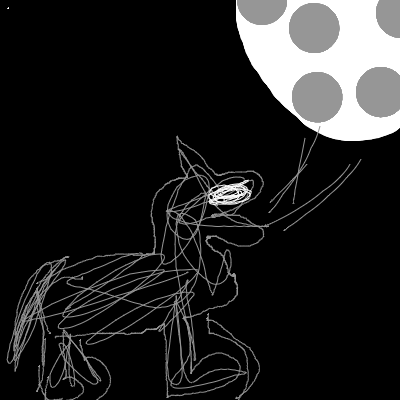

In [8]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
init_image = Image.open(p).convert("RGB")
init_image

In [9]:
prompts = ["Wolf howling at the moon, photorealistic 4K",""]

In [ ]:
processor??

In [10]:
inputs = processor(text=prompts, images=init_image, return_tensors="pt", padding=True)
 padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [11]:
with torch.no_grad():
    vision_outputs = model.vision_model(pixel_values=inputs.pixel_values.to(torch_device))
    text_outputs = model.text_model(input_ids=inputs.input_ids.to(torch_device))
    img_embeds = model.visual_projection(vision_outputs[1])
    txt_embeds = model.text_projection(text_outputs[1])
    img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)
    txt_embeds = txt_embeds / txt_embeds.norm(p=2, dim=-1, keepdim=True)
img_embeds.shape, txt_embeds.shape

(torch.Size([1, 768]), torch.Size([2, 768]))

In [12]:
# cosine similarity as logits
logit_scale = model.logit_scale.exp()
logits_per_text = torch.matmul(txt_embeds, img_embeds.t()) * logit_scale
logits_per_image = logits_per_text.t()

In [13]:
logits_per_image

tensor([[19.7719, 19.0408]], device='cuda:0', grad_fn=<TBackward0>)

In [14]:
probs = logits_per_image.softmax(dim=1);probs

tensor([[0.6750, 0.3250]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Embeddings are the last layers of CLIP model, to become comparable they need to be "projected" to the same (1,768) output.

In [15]:
init_image.size

(400, 400)

In [16]:
img = init_image.resize((400,400))

In [17]:
img_tensor = tfms.ToTensor()(img)
nul_img = torch.zeros_like(img_tensor);nul_img.shape

torch.Size([3, 400, 400])

## Latent to Image to Latent convertions

In [18]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [19]:
# from diffusers import StableDiffusionPipeline
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")    

## Diffusion Loop

In [48]:
# Some settings
prompts = ["A watercolor painting of an otter", ""]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
# generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
img = init_image # two cats
nul = nul_img #null image
images = [img_tensor, nul_img]

In [49]:
inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True)

In [50]:
with torch.no_grad():
    text_embeddings = model.text_model(input_ids=inputs.input_ids.to(torch_device))[0].half()
    image_embeddings = model.vision_model(pixel_values=inputs.pixel_values.to(torch_device))[0].half()
text_embeddings.shape, image_embeddings.shape, text_embeddings.type()

(torch.Size([2, 8, 768]), torch.Size([2, 257, 1024]), 'torch.cuda.HalfTensor')

In [32]:
max_length = inputs.input_ids.shape[-1]; max_length

8

In [37]:
uncond_input = processor.tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = model.text_model(uncond_input.input_ids.to(torch_device))[0].half()

In [39]:
uncond_embeddings, uncond_embeddings.shape

(tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4900, -0.3066,  0.0674],
          [-0.3711, -1.4492, -0.3401,  ...,  0.9487,  0.1868, -1.1035],
          [-0.5107, -1.4629, -0.2925,  ...,  1.0420,  0.0701, -1.0283],
          ...,
          [-0.5645, -1.3877, -0.2568,  ...,  1.1553, -0.1278, -1.0488],
          [-0.5586, -1.3857, -0.2512,  ...,  1.1953, -0.1794, -1.0723],
          [-0.5596, -1.3682, -0.2421,  ...,  1.2295, -0.2568, -1.1035]]],
        device='cuda:0', dtype=torch.float16),
 torch.Size([1, 8, 768]))

In [51]:
text_embeddings[1]

tensor([[-0.3884,  0.0229, -0.0522,  ..., -0.4900, -0.3066,  0.0674],
        [-0.3711, -1.4492, -0.3401,  ...,  0.9487,  0.1868, -1.1035],
        [-0.5107, -1.4629, -0.2925,  ...,  1.0420,  0.0701, -1.0283],
        ...,
        [-0.5645, -1.3877, -0.2568,  ...,  1.1553, -0.1278, -1.0488],
        [-0.5586, -1.3857, -0.2512,  ...,  1.1953, -0.1794, -1.0723],
        [-0.5596, -1.3682, -0.2421,  ...,  1.2295, -0.2568, -1.1035]],
       device='cuda:0', dtype=torch.float16)

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [24]:
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

In [25]:
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

In [26]:
latents.shape

torch.Size([1, 4, 64, 64])

In [27]:
latent_model_input = torch.cat([latents] * 2);latent_model_input.shape

torch.Size([2, 4, 64, 64])

In [28]:
# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i].half()
        # Scale the latents (preconditioning):
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

0it [00:00, ?it/s]

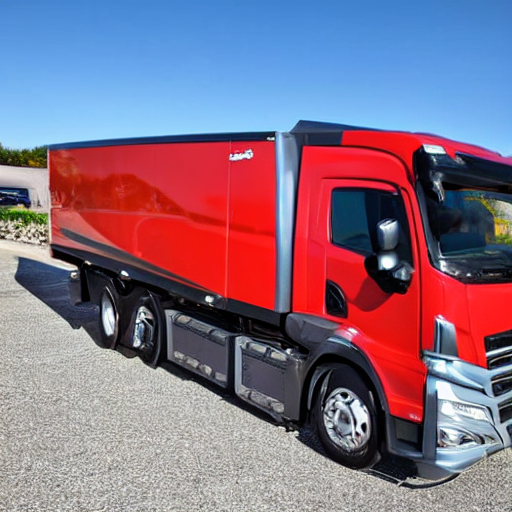

In [29]:
pil_images[0]